In [1]:
import pandas as pd
import pickle

#two ways of unpickling

train_dict = pd.read_pickle("./train.pickle")

test_data = open("./test.pickle", 'rb')
test_dict = pickle.load(test_data)

validation_data = open("./valid.pickle", 'rb')
validation_dict = pickle.load(validation_data)

train_dict.keys()

dict_keys(['coords', 'labels', 'features', 'sizes'])

In [4]:
from tensorflow.keras.utils import to_categorical
import numpy as np

x_train = train_dict['features']
y_train = train_dict['labels']
train_label = y_train
y_train = to_categorical(y_train)

x_test = test_dict['features']
y_test = test_dict['labels']
y_test = to_categorical(y_test)

x_validation = validation_dict['features']
y_validation = validation_dict['labels']
val_label = y_validation
y_validation = to_categorical(y_validation)

In [5]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_validation.shape, y_validation.shape)

(34799, 32, 32, 3) (34799, 43)
(12630, 32, 32, 3) (12630, 43)
(4410, 32, 32, 3) (4410, 43)


##  Conclusion from the above:
* We have 34799 training data, 12630 testing data and 4410 vaidation data.
* The data(images) are 32(width) * 32(height) * 3(RGB color channels).
* The traffic signs have 43 classes.

## Histograms of training and validation samples

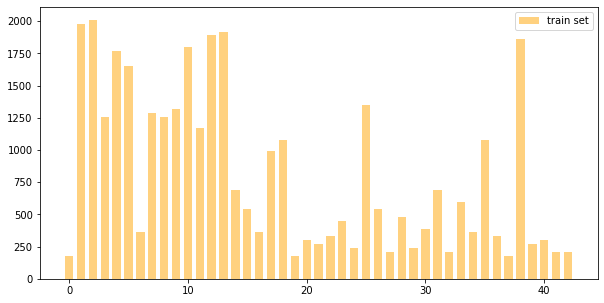

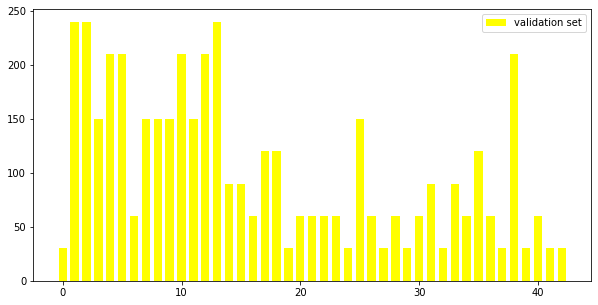

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))
width = 0.7
unique_tr, counts_tr = np.unique(train_label, return_counts=True)
plt.bar(unique_tr, counts_tr, width, alpha=0.5, label='train set', color='orange')
plt.legend(loc='upper right')
plt.show()

fig, ax = plt.subplots(figsize=(10,5))
width = 0.7
unique_v, counts_v = np.unique(val_label, return_counts=True)
plt.bar(unique_v, counts_v, width, alpha=1, label='validation set', color='yellow')
plt.legend(loc='upper right')
plt.show()

In [7]:
x_train.dtype, y_train.dtype 

(dtype('uint8'), dtype('float32'))

## Duplicating

In [8]:
d={}
for i,j in enumerate(x_train):
    tmp=d.get(train_label[i], [])
    tmp.append(j)
    d[train_label[i]]=tmp
d.keys()

dict_keys([41, 31, 36, 26, 23, 1, 40, 22, 37, 16, 3, 19, 4, 11, 42, 0, 32, 27, 29, 24, 9, 5, 38, 8, 10, 35, 34, 18, 6, 13, 7, 30, 39, 21, 20, 33, 28, 12, 14, 15, 17, 2, 25])

In [9]:
for i, j in d.items():
    l=len(j)
    ll=l
    while ll < 2700:
        d[i]=np.concatenate((d[i], j), axis=0)
        ll+=l
    np.random.shuffle(d[i])

In [ ]:
x_t=[]
y_t=[]
for i, j in d.items():
    x_t.append(j.tolist())
    for n in range(len(j)):
        y_t.append(i)
        
#x_t=np.array(x_t)
#y_t=np.array(y_t)

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))
width = 0.7
unique_tr, counts_tr = np.unique(y_t, return_counts=True)
plt.bar(unique_tr, counts_tr, width, alpha=0.5, label='train set', color='orange')
plt.legend(loc='upper right')
plt.show()

In [ ]:
x_train=x_t
y_train=y_t
train_label=y_train
y_train = to_categorical(y_train)

print(np.array(x_train).shape)
print(np.array(y_train).shape)

## Image normalization

Imagenormalizationis  a  typical processin  imageprocessingthat  changes the  range  of  pixel intensity values.Its normal purpose is to convert an input image into a rangeof pixel valuesthat aremore familiar or normal to the senses, hence the term normalization.
http://dev.ipol.im/~nmonzon/Normalization.pdf


## Normalizing RGB

RGB (Red, Green, Blue) are 8 bit each.
The range for each individual color is 0-255 (as 2^8 = 256 possibilities).
The combination range is 256*256*256.
By dividing by 255, the 0-255 range can be described with a 0.0-1.0 range where 0.0 means 0 (0x00) and 1.0 means 255 (0xFF).


## Changing color space

A color space is a protocol for representing colors in a way that makes them easily reproducible. We know that grayscale images have single pixel values and color images contain 3 values for each pixel – the intensities of the Red, Green and Blue channels.

We are using openCV(cvtColor()) in purpose of converting RGB into grayscale so that the computation would be less.


## Histogram Equalization

Histogram Equalization is the process taking a low contrast image and increasing the contrast between the image’s relative highs and lows in order to bring out subtle differences in shade and create a higher contrast image. The results can be striking, especially for grayscale images.
https://towardsdatascience.com/image-augmentation-for-deep-learning-using-keras-and-histogram-equalization-9329f6ae5085

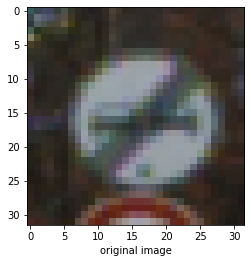

In [7]:
import matplotlib.pyplot as plt

img = x_train[71]
plt.xlabel('original image')
plt.imshow(img)
plt.show()

In [8]:
import cv2
from skimage import exposure 

def processing(img): 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    #img = cv2.equalizeHist(img) 
    img = img / 255.0
    img = exposure.equalize_adapthist(img)
    return img 

x_train = np.array(list(map(processing, x_train))) 
x_validation = np.array(list(map(processing, x_validation))) 
x_test = np.array(list(map(processing, x_test))) 

#reshaping data(if we convert it to grayscale)
x_train = x_train.reshape(34799, 32, 32, 1) 
x_validation = x_validation.reshape(4410, 32, 32, 1) 
x_test = x_test.reshape(12630, 32, 32, 1) 

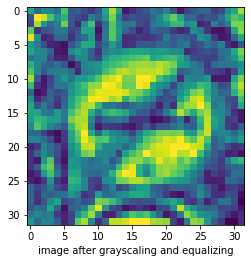

In [9]:
import matplotlib.pyplot as plt

img = x_train[71]
plt.xlabel('image after grayscaling and equalizing')
plt.imshow(img)
plt.show()

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

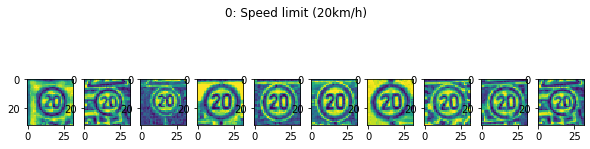

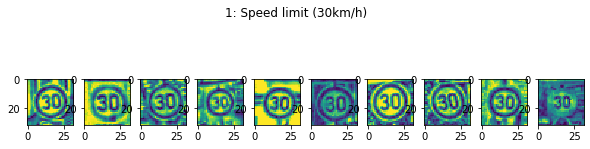

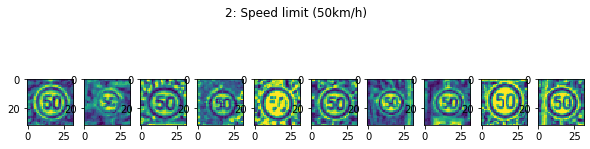

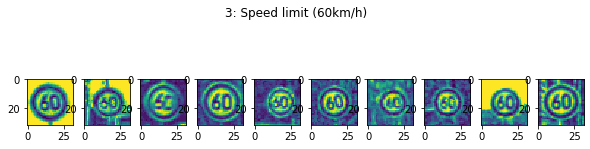

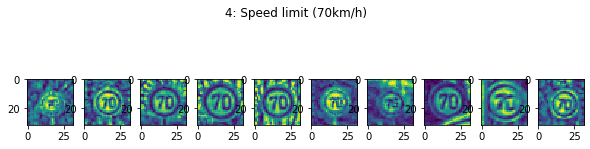

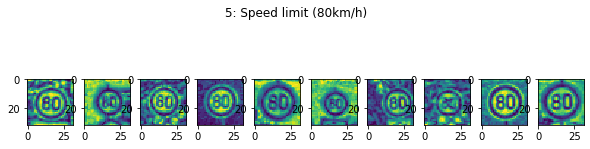

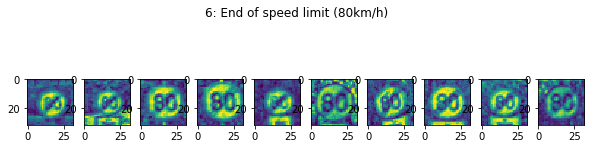

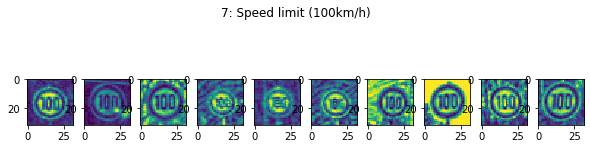

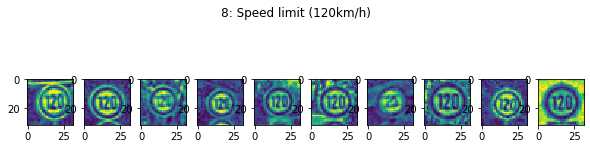

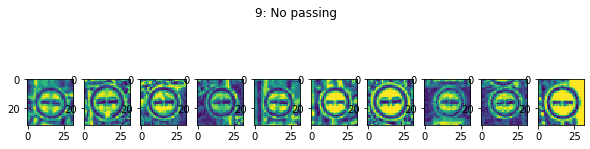

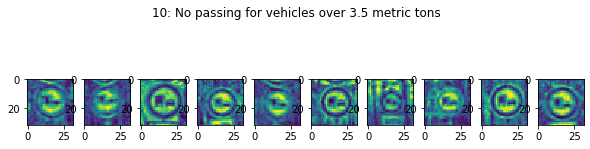

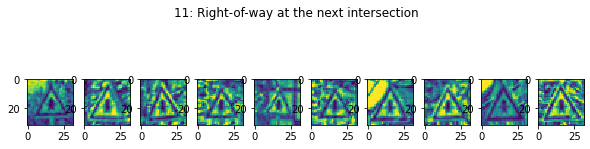

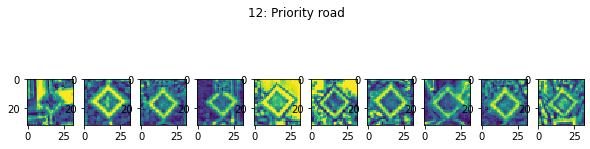

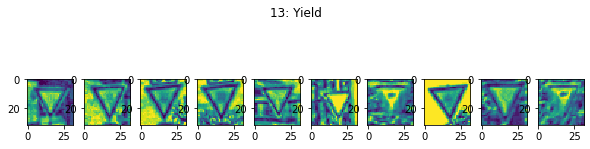

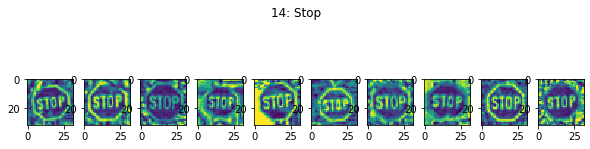

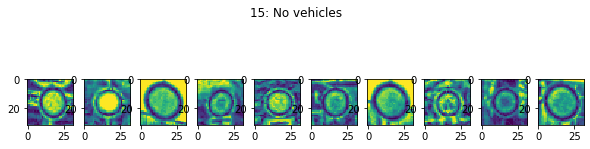

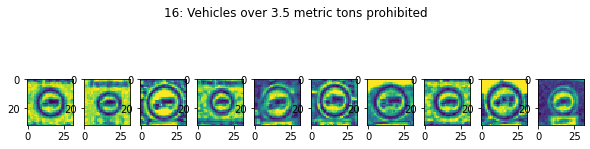

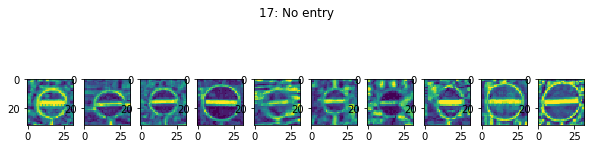

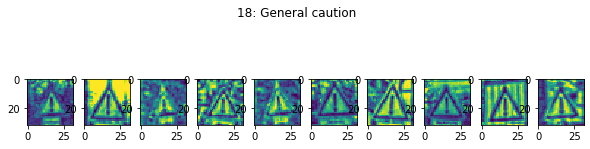

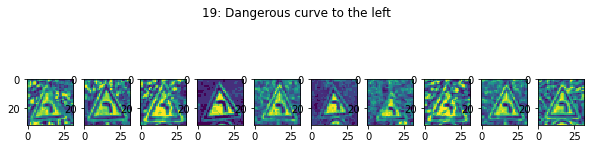

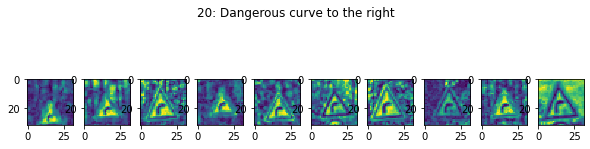

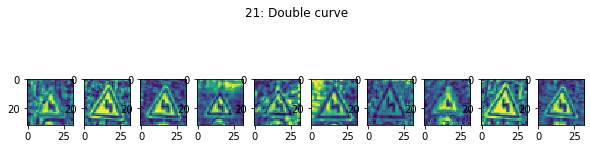

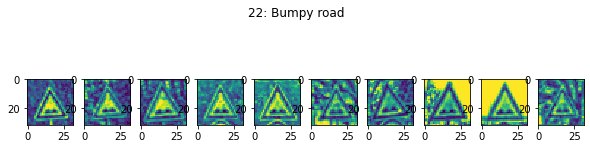

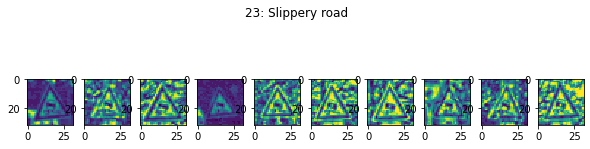

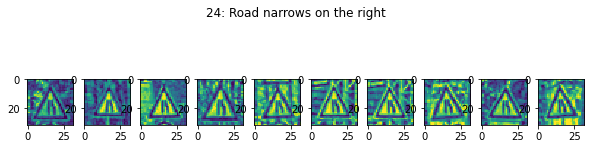

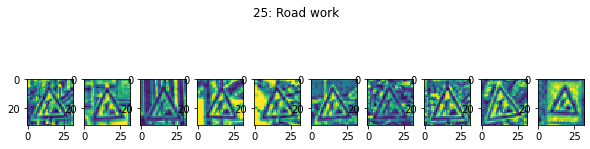

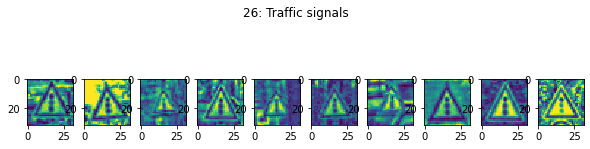

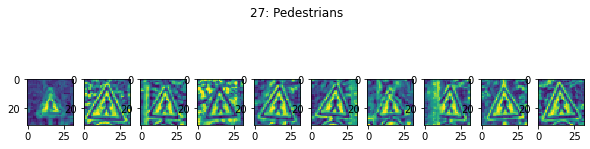

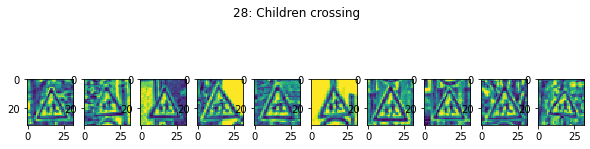

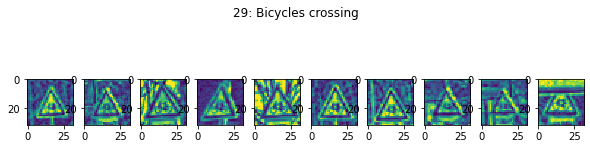

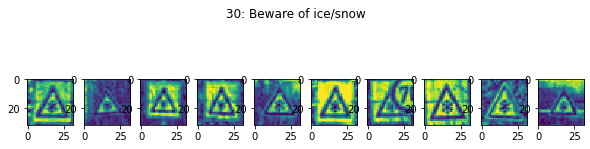

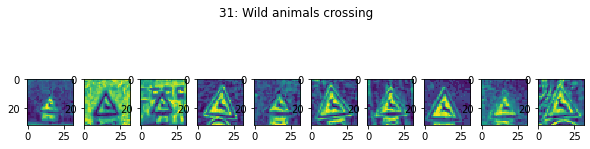

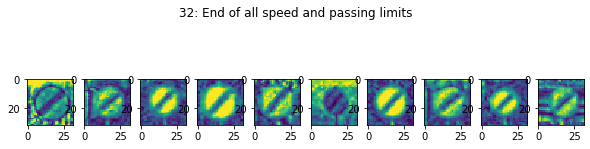

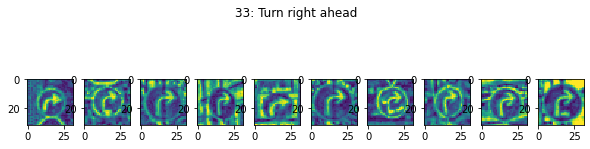

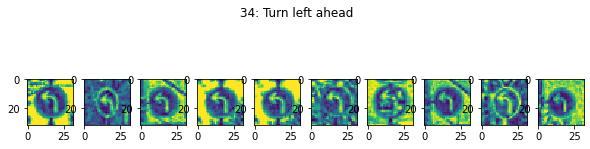

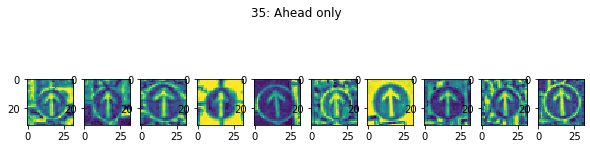

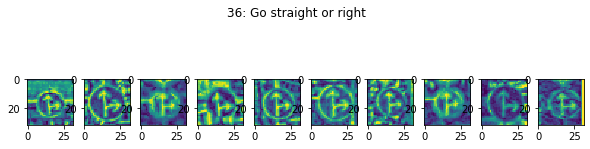

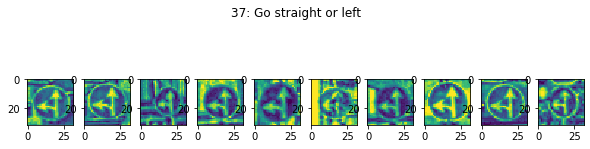

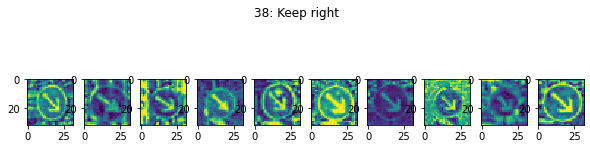

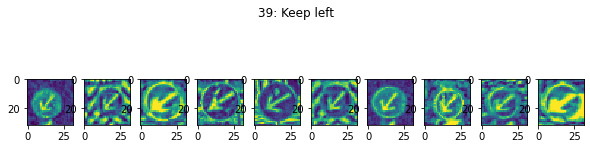

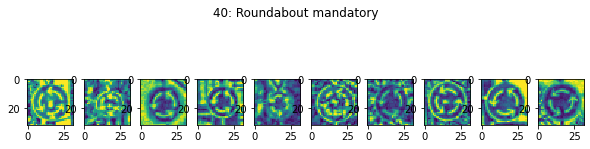

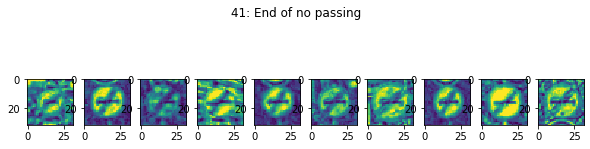

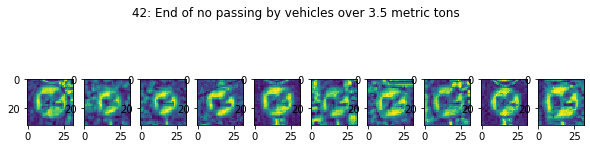

In [11]:
import numpy as np
import random
import csv

#getting the labels from label_names.csv
with open('label_names.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader, None)
    sign_names = list(reader)
    
labels = np.unique(val_label)

for label in labels:
    label_indices = np.where(train_label == label)[0]
    fig = plt.figure(figsize = (10, 10))
    for i in range(10):
        rand_index = random.choice(label_indices)
        sub = fig.add_subplot(10, 10, i+1)
        sub.imshow(x_train[rand_index], interpolation = 'nearest')
    plt.suptitle(str(label) + ': ' + sign_names[label][1])
    plt.show()

In [12]:
Training_data = datagen.flow(x_train,
                             y=y_train,
                            batch_size = 256)

Validation_data = datagen.flow(x_validation,
                             y=y_validation,
                            batch_size = 256)

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_best_only=True)

from tensorflow.keras.callbacks import ReduceLROnPlateau
lrr= ReduceLROnPlateau(
                       monitor='val_acc', #Metric to be measured
                       factor=.01, #Factor by which learning rate will be reduced
                       patience=3,  #No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
                       min_lr=1e-5) #The minimum learning rate
'''Learning Rate Annealer: The learning rate can be modified after a set number of epochs or after a certain condition is met. We will use the latter and change the learning rate if 
the validation error does not reduce after a set number of epochs. To do this we will use the patience parameter.'''

'Learning Rate Annealer: The learning rate can be modified after a set number of epochs or after a certain condition is met. We will use the latter and change the learning rate if \nthe validation error does not reduce after a set number of epochs. To do this we will use the patience parameter.'

In [14]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, AveragePooling2D, Flatten,Dense, Dropout
from tensorflow.keras import Model

input_model = Input((x_train.shape[1], x_train.shape[2], x_train.shape[3]), name = 'input_layer')

model1 = Conv2D(32, (5,5), activation='relu',name ='Conv1_5')(input_model)
model1 = BatchNormalization(name = 'Bnorrm1')(model1)
model1 = Conv2D(32, (5,5), activation='relu', padding='same', name='Conv2_5')(model1)
model1 = BaیtchNormalization(name = 'Bnorrm2')(model1)
model1 = MaxPooling2D((2, 2), name='MaxPool1')(model1)
model1 = Conv2D(64, (3,3), activation='relu', padding='same', name ='Conv3_3')(model1)
model1 = BatchNormalization(name = 'Bnorrm3')(model1)
model1 = Conv2D(64, (3,3), activation='relu', padding='same', name ='Conv4_3')(model1)
model1 = BatchNormalization(name = 'Bnorrm4')(model1)
model1 = AveragePooling2D((2, 2), name='AvgPool1')(model1)
model1 = Conv2D(128, (1,1), activation='relu', padding='valid', name ='Conv5_1')(model1)
model1 = BatchNormalization(name = 'Bnorrm5')(model1)

#######################################################################################################

model1 = Flatten(name='Flatten')(model1)

#######################################################################################################

model1 = Dense(units=32, activation='relu')(model1)
model1 = Dropout(rate=0.2)(model1)
model1 = BatchNormalization()(model1)
model1 = Dense(units=20, activation='relu')(model1)
model1 = BatchNormalization()(model1)
model1 = Dense(units=15, activation='relu')(model1)
model1 = BatchNormalization()(model1)

output = Dense(units=43, activation='softmax', name='preds')(model1)


model = Model(inputs=[input_model], outputs=[output])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 32, 32, 1)]       0         
_________________________________________________________________
Conv1_5 (Conv2D)             (None, 28, 28, 32)        832       
_________________________________________________________________
Bnorrm1 (BatchNormalization) (None, 28, 28, 32)        128       
_________________________________________________________________
Conv2_5 (Conv2D)             (None, 28, 28, 32)        25632     
_________________________________________________________________
Bnorrm2 (BatchNormalization) (None, 28, 28, 32)        128       
_________________________________________________________________
MaxPool1 (MaxPooling2D)      (None, 14, 14, 32)        0         
_________

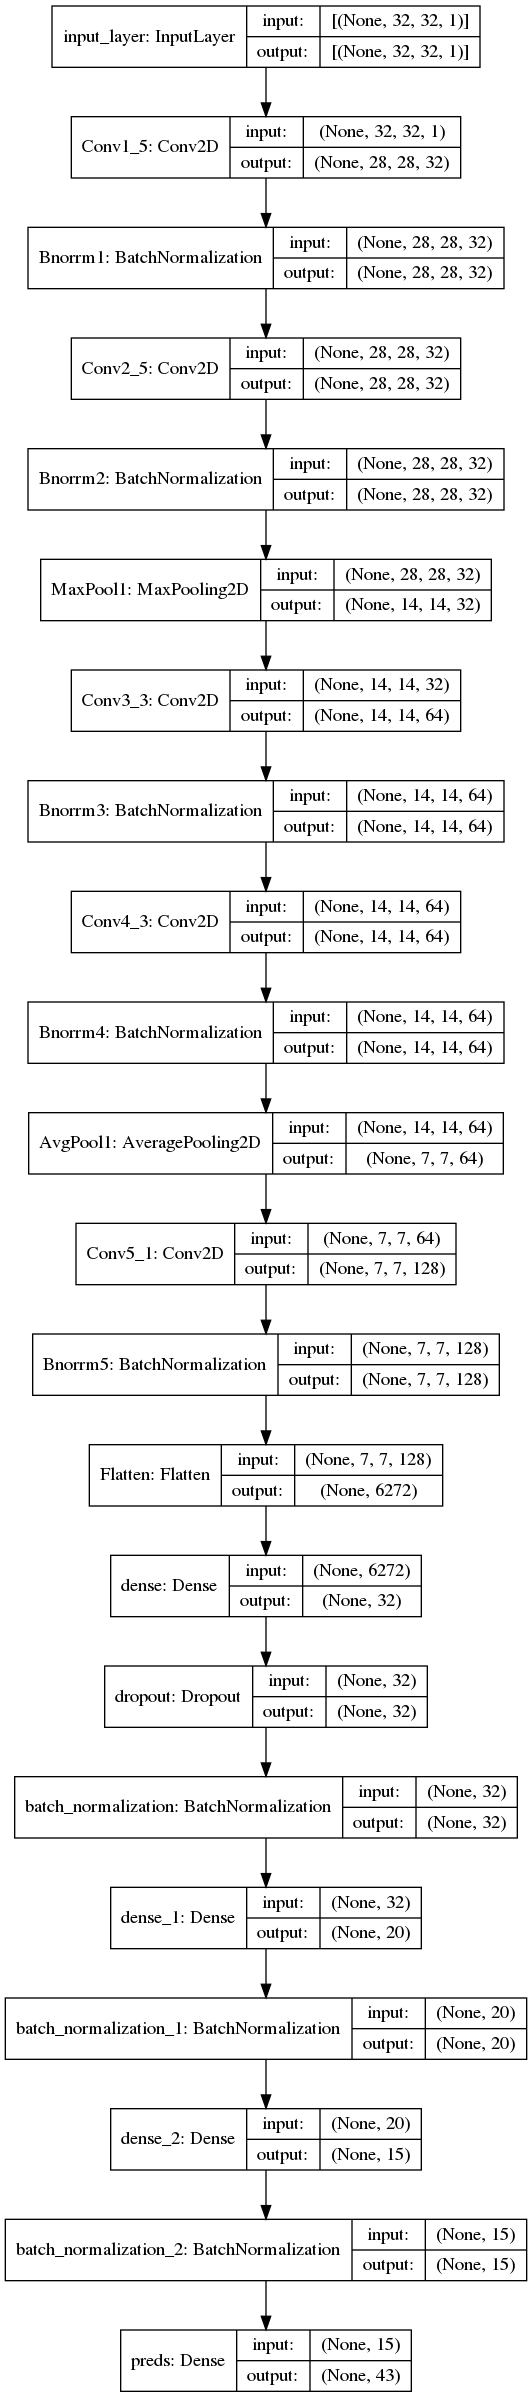

In [15]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

In [16]:
layer_names = []
for layer in model.layers[1:14]:
    layer_names.append(layer.name)

layer_names

['Conv1_5',
 'Bnorrm1',
 'Conv2_5',
 'Bnorrm2',
 'MaxPool1',
 'Conv3_3',
 'Bnorrm3',
 'Conv4_3',
 'Bnorrm4',
 'AvgPool1',
 'Conv5_1',
 'Bnorrm5',
 'Flatten']

In [22]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model

sgd = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
history = model.fit_generator(Training_data, 
                              epochs=10,
                              validation_data= Validation_data,
                              verbose=1,
                              callbacks=[checkpointer])

Epoch 1/10
 19/136 [===>..........................] - ETA: 3:12 - loss: 2.8203 - acc: 0.3170

KeyboardInterrupt: 

In [22]:
#model.save('ef5.h6')

In [ ]:
val_loss = history.history['val_loss']
loss = history.history['loss']

plt.plot(val_loss)
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Val error','Train error'], loc='upper right')
#plt.savefig('plot_error6.png')
plt.show()

In [ ]:
val_accuracy = history.history['val_acc']
accuracy = history.history['acc']

plt.plot(val_accuracy)
plt.plot(accuracy)
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['Val accuracy','Train accuracy'], loc='upper right')
#plt.savefig( 'plot_accuracy6.png')
plt.show()

In [30]:
y_prediction = model.predict(x_test)

y_pred = np.argmax(y_prediction, axis=1)
print(y_pred)

[16  1 38 ...  6  7 10]


In [31]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(y_test,axis=1), y_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.97        60
           1       0.97      0.99      0.98       720
           2       1.00      0.95      0.97       750
           3       0.99      0.97      0.98       450
           4       0.98      0.99      0.99       660
           5       0.94      0.98      0.96       630
           6       0.99      0.96      0.98       150
           7       0.97      1.00      0.98       450
           8       0.96      0.98      0.97       450
           9       0.99      0.97      0.98       480
          10       0.98      1.00      0.99       660
          11       0.94      0.92      0.93       420
          12       0.99      0.98      0.99       690
          13       0.99      1.00      0.99       720
          14       1.00      0.99      0.99       270
          15       1.00      1.00      1.00       210
          16       1.00      1.00      1.00       150
          17       1.00    

In [27]:
from sklearn.metrics import accuracy_score

score = accuracy_score(arg_y_test, y_pred)
print(round(score*100, 2))


95.95


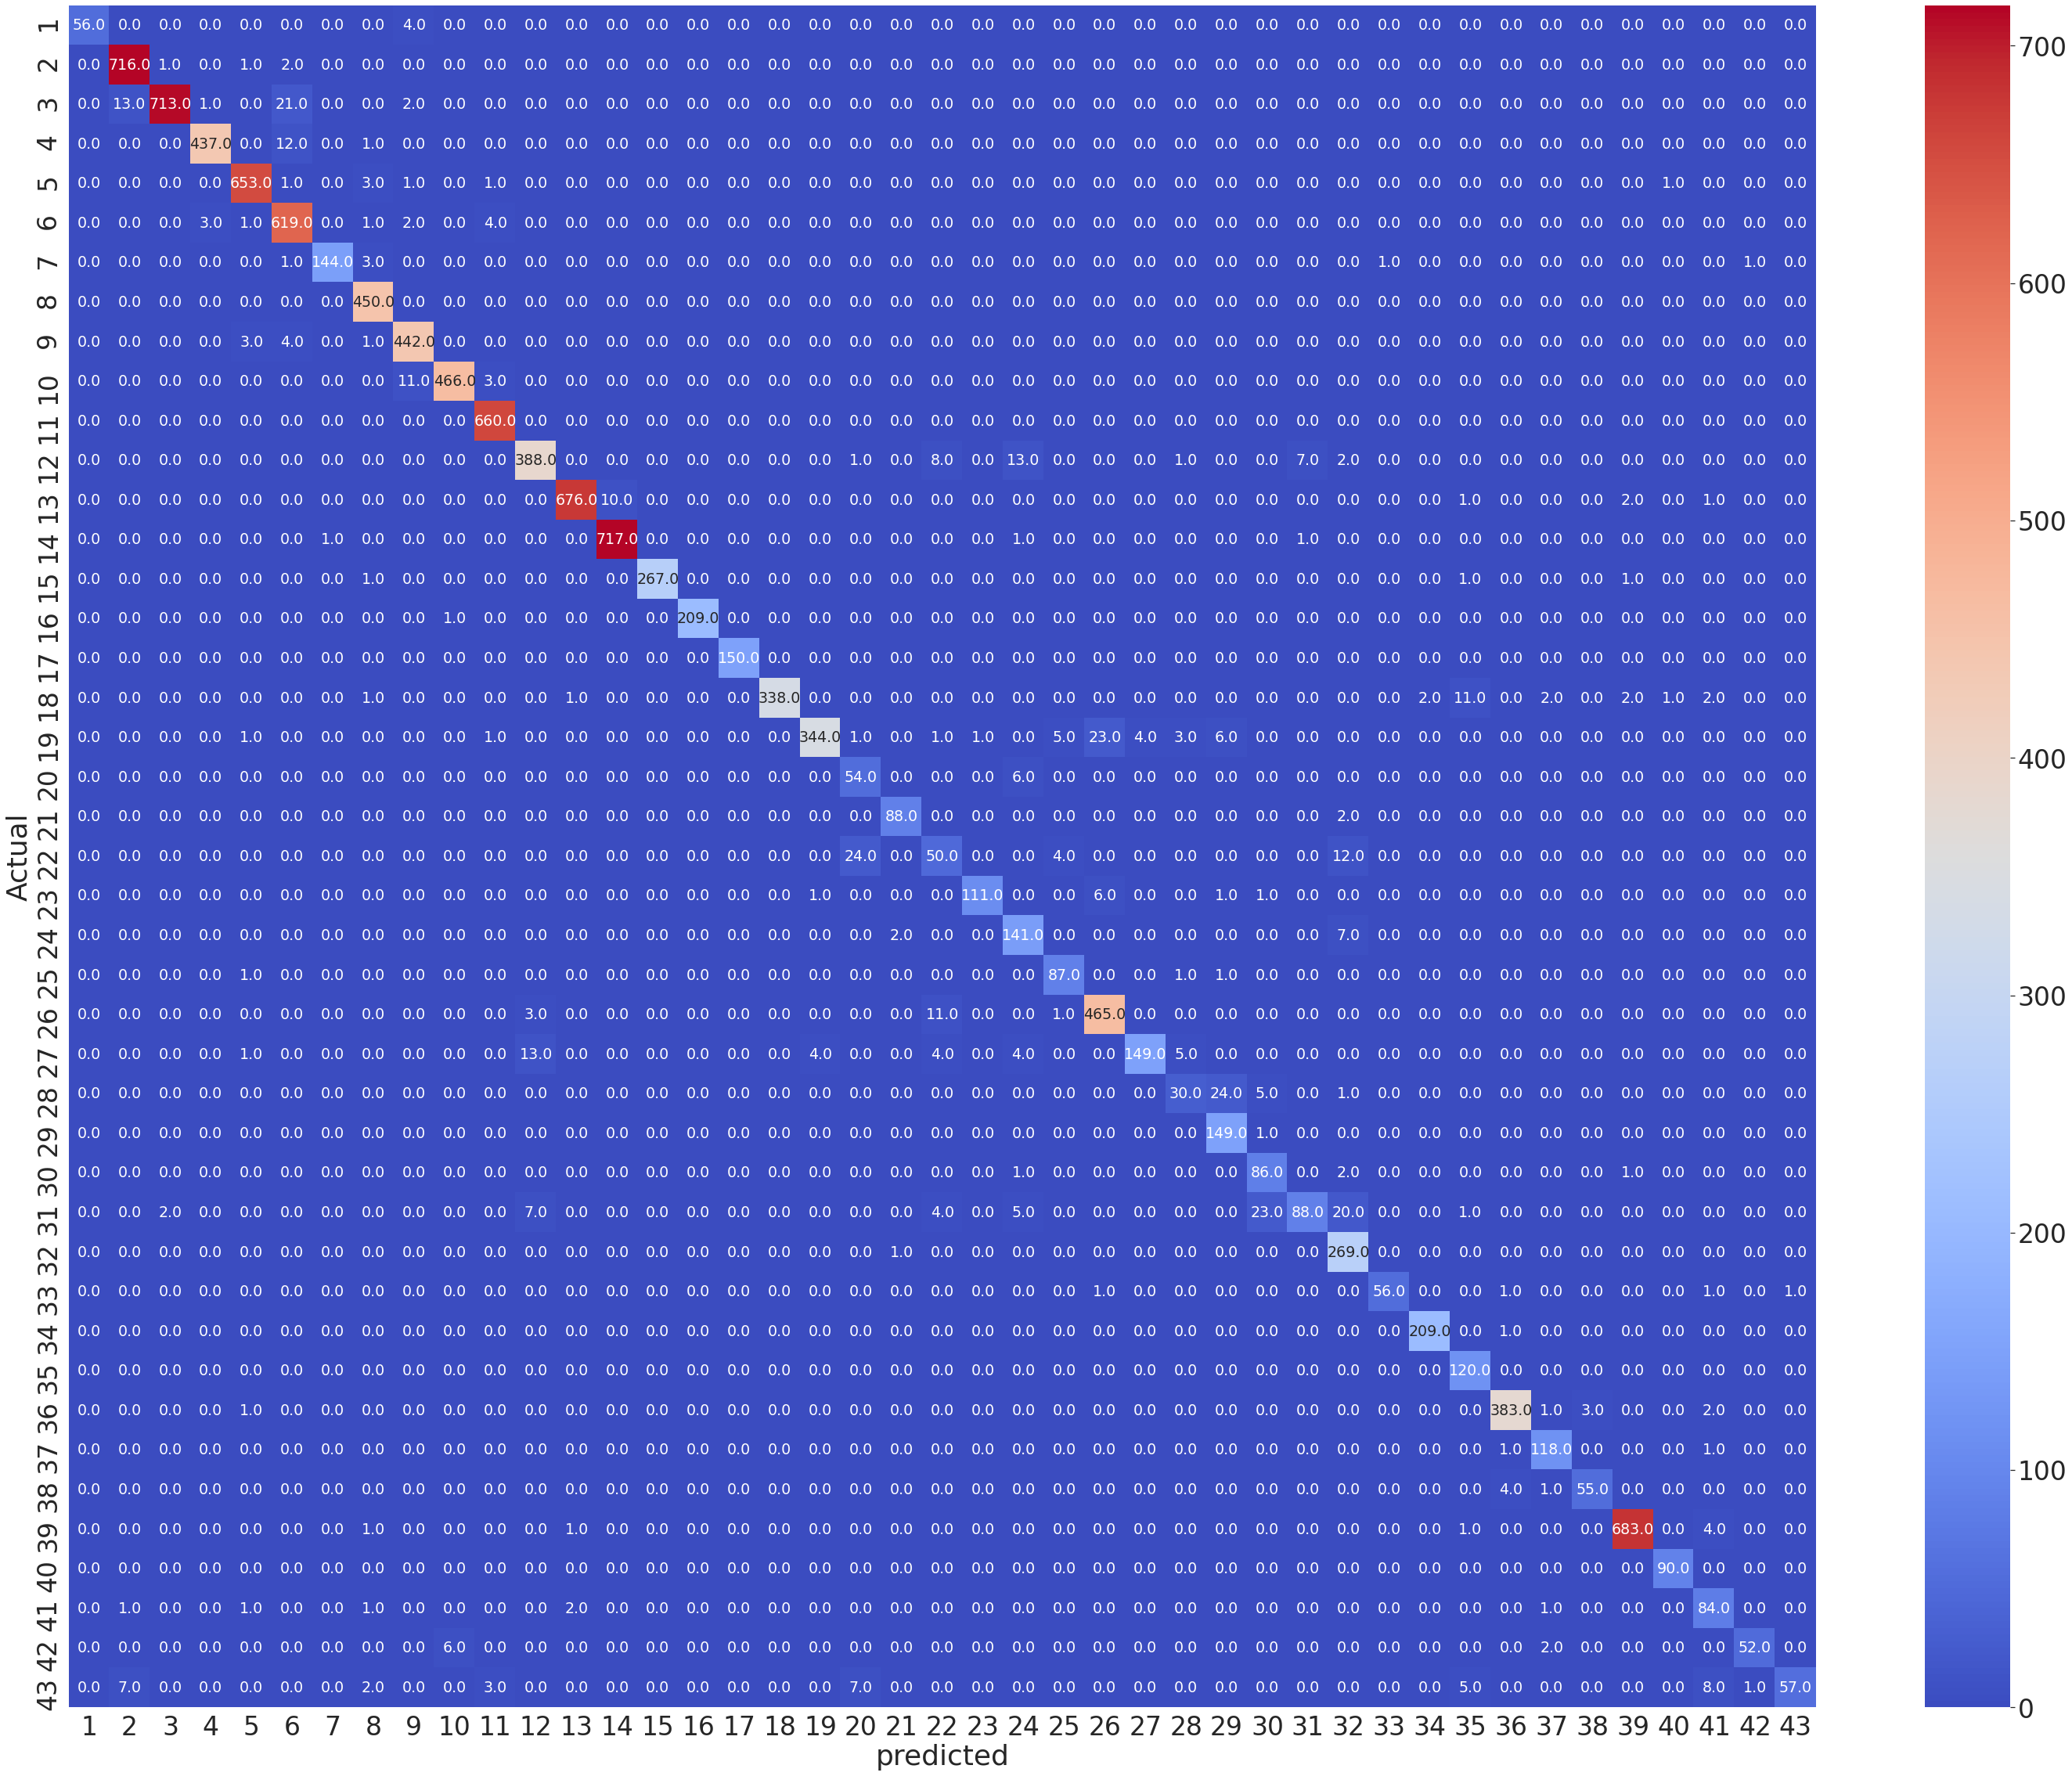

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

true=[]
pr=[]
for i in range(43):
    true.append(i+1)
    pr.append(i+1)
arg_y_test=np.argmax(y_test,axis=1)
ddata=confusion_matrix(arg_y_test,y_pred)
df=pd.DataFrame(ddata, columns=np.unique(true), index=np.unique(true))
df.index.name='Actual'
df.columns.name='predicted'
plt.figure(figsize=(50,40))
sns.set(font_scale=3)
sns.heatmap(df, cmap='coolwarm', annot=True, fmt=".1f", annot_kws={'size':19})

#plt.savefig('confusion_matrix6.png')

layer : Conv1_5 , feature map shape : (1, 28, 28, 32)
nrow : 1 , ncol : 5


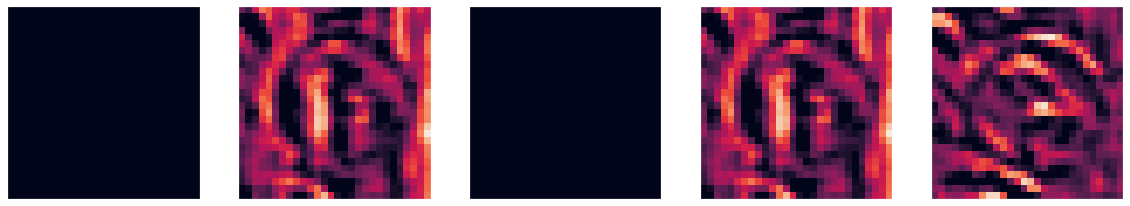

layer : Bnorrm1 , feature map shape : (1, 28, 28, 32)
nrow : 1 , ncol : 5


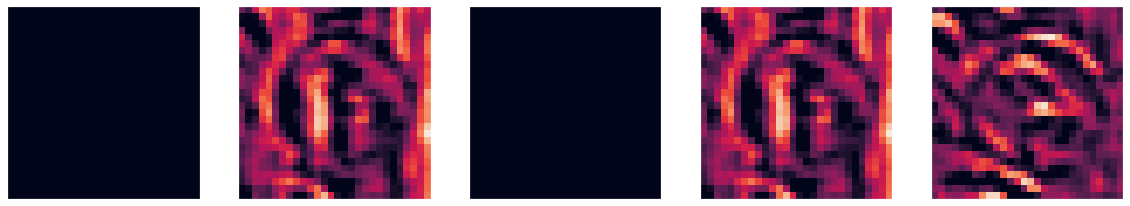

layer : Conv2_5 , feature map shape : (1, 28, 28, 32)
nrow : 1 , ncol : 5


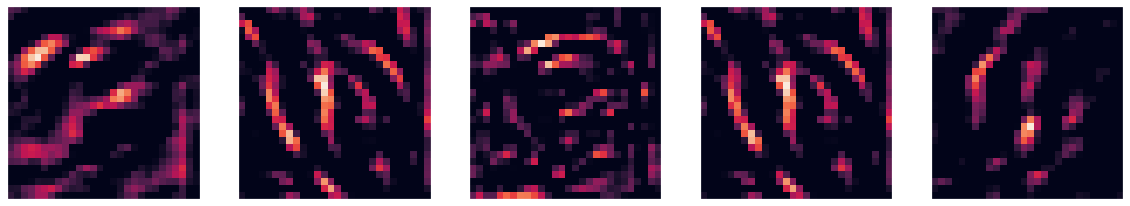

layer : Bnorrm2 , feature map shape : (1, 28, 28, 32)
nrow : 1 , ncol : 5


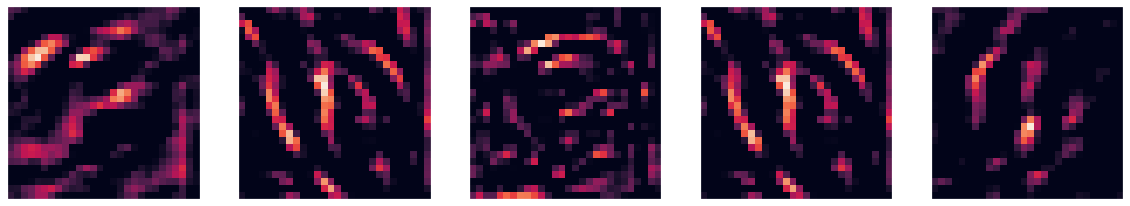

layer : MaxPool1 , feature map shape : (1, 14, 14, 32)
nrow : 1 , ncol : 5


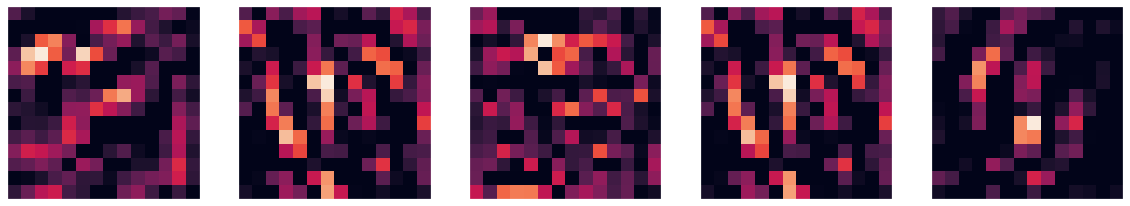

layer : Conv3_3 , feature map shape : (1, 14, 14, 64)
nrow : 1 , ncol : 5


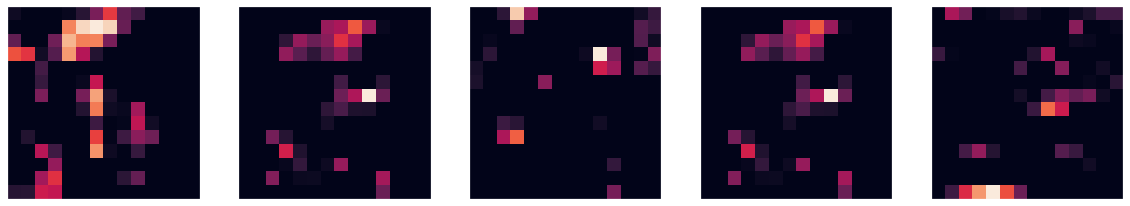

layer : Bnorrm3 , feature map shape : (1, 14, 14, 64)
nrow : 1 , ncol : 5


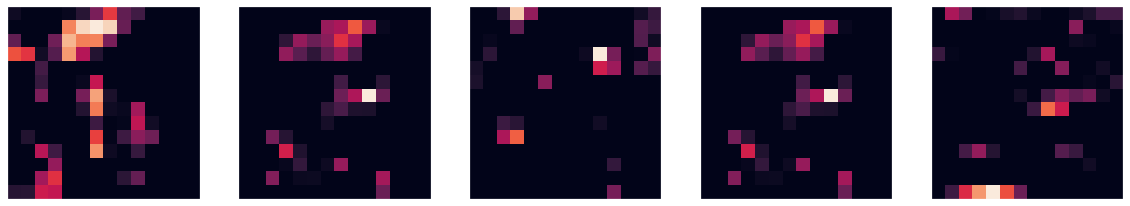

layer : Conv4_3 , feature map shape : (1, 14, 14, 64)
nrow : 1 , ncol : 5


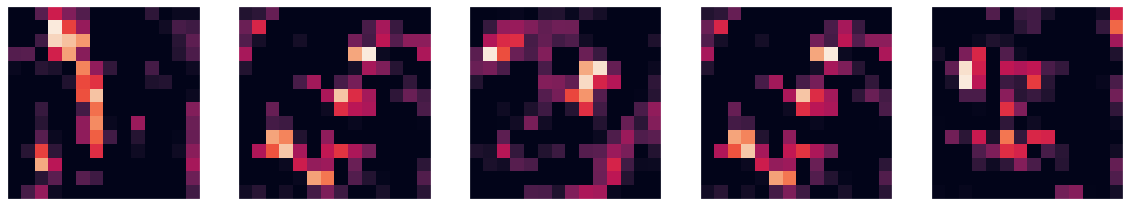

layer : Bnorrm4 , feature map shape : (1, 14, 14, 64)
nrow : 1 , ncol : 5


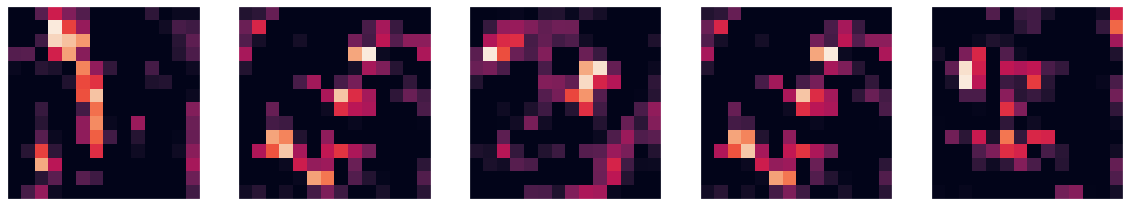

layer : AvgPool1 , feature map shape : (1, 7, 7, 64)
nrow : 1 , ncol : 5


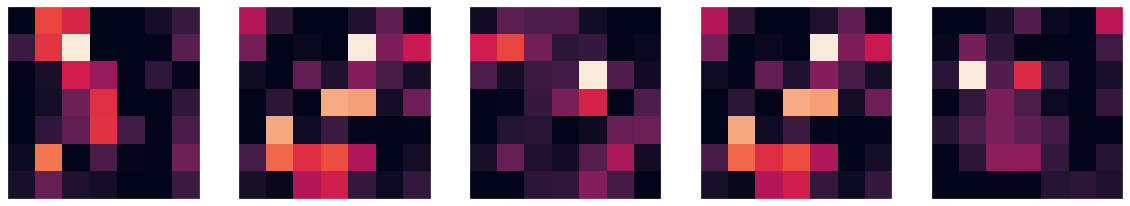

layer : Conv5_1 , feature map shape : (1, 7, 7, 128)
nrow : 1 , ncol : 5


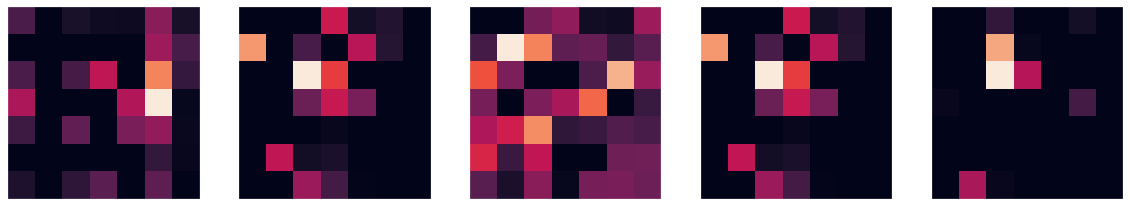

layer : Bnorrm5 , feature map shape : (1, 7, 7, 128)
nrow : 1 , ncol : 5


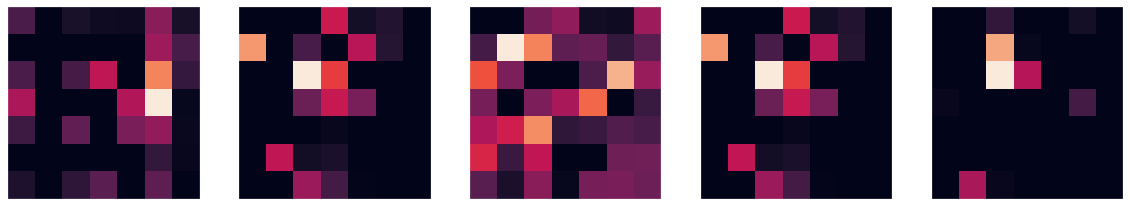

In [32]:
rand_pic = []
for n_layer in range(1,13):
  model_layer = Model(inputs=model.inputs, outputs=model.layers[n_layer].output)
  #(1,32,32,3) for RGB and (1,32,32,1) for grayscale
  feature_maps = model_layer.predict(x_train[17].reshape(1,32,32,1))
  print('layer : {} , feature map shape : {}'.format(model.layers[n_layer].name,feature_maps.shape))

  n_row = 1
  n_col = 5
  for i in range(9):
        pic=random.randrange(feature_maps.shape[-1])
        rand_pic.append(pic)
        
  print('nrow : {} , ncol : {}'.format(n_row,n_col))
  plt.figure(figsize=(20,15))
  # plot all maps in an shape/8 * 8 squares
  ix = 1
  for r in range(n_row):
    for c in range(n_col):
    # specify subplot and turn of axis
        ax = plt.subplot(n_row, n_col, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[0, :, :, rand_pic[c]])
        ix += 1
  # show the figure
  plt.show()